In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_panda = pd.read_csv("./auto-mpg.csv")
data_panda.head()

data_panda = data_panda.drop('car name',1)

data_panda = data_panda.drop(data_panda[data_panda["horsepower"] == "?"].index)

sns.pairplot(data_panda)
plt.show()

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_2188/1256180727.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_panda = data_panda.drop('car name',1)


In [3]:
dummy_fields = ['cylinders', 'model year', 'origin']
for each in dummy_fields:
    dummies = pd.get_dummies(data_panda[each], prefix=each, drop_first=False)
    data_panda = pd.concat([data_panda, dummies], axis=1)

data_panda = data_panda.astype(float)

data_panda = data_panda.drop(['cylinders'],axis = 1)
data_panda = data_panda.sample(frac=1).reset_index(drop=True)

train_data = data_panda[:-79]
test_data = data_panda[-79:]

quant_features = ['mpg','displacement', 'horsepower', 'weight']
scaled_features = {}
for each in quant_features:
    mean, std = train_data[each].mean(), train_data[each].std()
    scaled_features[each] = [mean, std]
    train_data.loc[:, each] = (train_data[each] - mean)/std
    test_data.loc[:, each] = (test_data[each] - mean)/std
    

train_target, train_inputs = train_data['mpg'],train_data.drop('mpg',axis=1)
test_target, test_inputs = test_data['mpg'],test_data.drop('mpg',axis=1)

print(train_inputs)

train_target = train_target.to_numpy()
train_inputs = train_inputs.to_numpy()

test_target = test_target.to_numpy()
test_inputs = test_inputs.to_numpy()

     displacement  horsepower    weight  acceleration  model year  origin  \
0        0.516049   -0.129006  0.335766          15.0        71.0     1.0   
1        0.275005   -0.129006  0.776078          17.7        76.0     1.0   
2       -0.592751   -0.554046 -0.567528          16.0        82.0     1.0   
3       -0.949495   -0.979086 -1.032898          16.6        78.0     3.0   
4       -0.727735    0.136644 -0.406439          14.0        73.0     2.0   
..            ...         ...       ...           ...         ...     ...   
308      0.679958    0.535119  0.721188          15.0        79.0     1.0   
309      1.046344    1.066419  1.049333          12.5        77.0     1.0   
310      1.962309    1.199244  1.746195          12.0        73.0     1.0   
311      1.017419    0.933594  0.535040          10.5        70.0     1.0   
312     -0.544542   -0.580611 -0.431497          17.0        75.0     1.0   

     cylinders_3  cylinders_4  cylinders_5  cylinders_6  ...  model year_76

C:\Users\saksh\.conda\envs\tf\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [4]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

0.8399947000486503
Root Mean Squared Error: 0.444


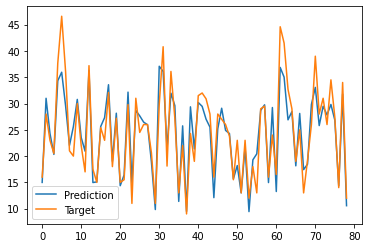

In [6]:
regr = linear_model.LinearRegression()
regr.fit(train_inputs, train_target)

prediction  = regr.predict(test_inputs)
print(regr.score(test_inputs,test_target))

print("Root Mean Squared Error: {:.3f}".format(np.sqrt(np.mean((test_target-prediction)**2))))


prediction = prediction*scaled_features['mpg'][1] + scaled_features['mpg'][0]
test_target1 = test_target*scaled_features['mpg'][1] + scaled_features['mpg'][0]
#Values are unnormalised
plt.plot(prediction, label = 'Prediction')
plt.plot(test_target1, label = 'Target')
plt.legend()


0.8233523779235404
Root Mean Squared Error: 0.466


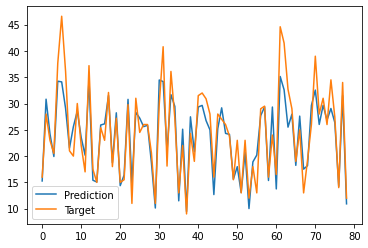

In [7]:
regr = svm.SVR(kernel='linear')
regr.fit(train_inputs, train_target)
prediction  = regr.predict(test_inputs)
print(regr.score(test_inputs,test_target))

print("Root Mean Squared Error: {:.3f}".format(np.sqrt(np.mean((test_target-prediction)**2))))


prediction = prediction*scaled_features['mpg'][1] + scaled_features['mpg'][0]
test_target1 = test_target*scaled_features['mpg'][1] + scaled_features['mpg'][0]
#Values are unnormalised
plt.plot(prediction, label = 'Prediction')
plt.plot(test_target1, label = 'Target')
plt.legend()




0.8408248239196106
Root Mean Squared Error: 0.443


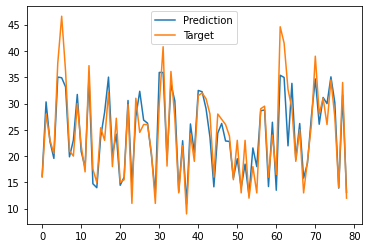

In [9]:
train_inputs.shape

(313, 27)

In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape= [train_inputs.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()


EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_inputs, train_target, 
                    epochs=EPOCHS, validation_split = 0.2, 
                    callbacks=[early_stop])


Epoch 1/1000
8/8 [==============================] - 1s 54ms/step - loss: 10.5866 - mae: 1.9466 - mse: 10.5866 - val_loss: 1.2961 - val_mae: 0.9873 - val_mse: 1.2961
Epoch 2/1000
8/8 [==============================] - 0s 11ms/step - loss: 1.1172 - mae: 0.8551 - mse: 1.1172 - val_loss: 0.9961 - val_mae: 0.8027 - val_mse: 0.9961
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.7121 - mae: 1.0821 - mse: 1.7121 - val_loss: 2.4621 - val_mae: 1.3059 - val_mse: 2.4621
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 2.6360 - mae: 1.4085 - mse: 2.6360 - val_loss: 0.7568 - val_mae: 0.6622 - val_mse: 0.7568
Epoch 5/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.6039 - mae: 0.6128 - mse: 0.6039 - val_loss: 0.7591 - val_mae: 0.6389 - val_mse: 0.7591
Epoch 6/1000
8/8 [==============================] - 0s 11ms/step - loss: 2.5842 - mae: 1.3712 - mse: 2.5842 - val_loss: 0.9756 - val_mae: 0.7608 - val_mse: 0.9756
Epoch 7/1000
8/8 [====

Root Mean Squared Error: 1.501


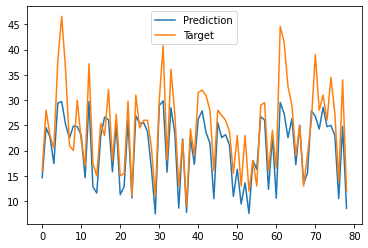

In [11]:
prediction = model(test_inputs)
print("Root Mean Squared Error: {:.3f}".format(np.sqrt(np.mean((test_target-prediction)**2))))

prediction = prediction*scaled_features['mpg'][1] + scaled_features['mpg'][0]
test_target1 = test_target*scaled_features['mpg'][1] + scaled_features['mpg'][0]
#Values are unnormalised
plt.plot(prediction, label = 'Prediction')
plt.plot(test_target1, label = 'Target')
plt.legend()


In [12]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation='relu', input_shape= [train_inputs.shape[1]])
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()


EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(train_inputs, train_target, 
                    epochs=EPOCHS, validation_split = 0.2, 
                    callbacks=[early_stop])

Epoch 1/1000
8/8 [==============================] - 1s 43ms/step - loss: 11.8094 - mae: 3.2688 - mse: 11.8094 - val_loss: 8.4228 - val_mae: 2.7051 - val_mse: 8.4228
Epoch 2/1000
8/8 [==============================] - 0s 10ms/step - loss: 6.3401 - mae: 2.3159 - mse: 6.3401 - val_loss: 5.0268 - val_mae: 2.0504 - val_mse: 5.0268
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 3.7155 - mae: 1.7106 - mse: 3.7155 - val_loss: 3.0870 - val_mae: 1.5743 - val_mse: 3.0870
Epoch 4/1000
8/8 [==============================] - 0s 11ms/step - loss: 2.2306 - mae: 1.2892 - mse: 2.2306 - val_loss: 1.9532 - val_mae: 1.2126 - val_mse: 1.9532
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.4603 - mae: 1.0351 - mse: 1.4603 - val_loss: 1.4158 - val_mae: 1.0103 - val_mse: 1.4158
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.1262 - mae: 0.9025 - mse: 1.1262 - val_loss: 1.1586 - val_mae: 0.9138 - val_mse: 1.1586
Epoch 7/1000
8/8 [=====

Epoch 51/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6882 - mae: 0.6988 - mse: 0.6882 - val_loss: 0.8655 - val_mae: 0.7755 - val_mse: 0.8655
Epoch 52/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6860 - mae: 0.6979 - mse: 0.6860 - val_loss: 0.8646 - val_mae: 0.7751 - val_mse: 0.8646
Epoch 53/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6796 - mae: 0.6887 - mse: 0.6796 - val_loss: 0.8496 - val_mae: 0.7789 - val_mse: 0.8496
Epoch 54/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6806 - mae: 0.6965 - mse: 0.6806 - val_loss: 0.8621 - val_mae: 0.7737 - val_mse: 0.8621
Epoch 55/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.6809 - mae: 0.6901 - mse: 0.6809 - val_loss: 0.8505 - val_mae: 0.7742 - val_mse: 0.8505
Epoch 56/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6788 - mae: 0.6934 - mse: 0.6788 - val_loss: 0.8598 - val_mae: 0.7719 - val_mse: 0.8598
Epoch 57/1000
8/8 [==

8/8 [==============================] - 0s 9ms/step - loss: 0.6121 - mae: 0.6481 - mse: 0.6121 - val_loss: 0.7701 - val_mae: 0.7339 - val_mse: 0.7701
Epoch 102/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6137 - mae: 0.6486 - mse: 0.6137 - val_loss: 0.7779 - val_mae: 0.7361 - val_mse: 0.7779
Epoch 103/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.6098 - mae: 0.6457 - mse: 0.6098 - val_loss: 0.7688 - val_mae: 0.7327 - val_mse: 0.7688
Epoch 104/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.6106 - mae: 0.6431 - mse: 0.6106 - val_loss: 0.7637 - val_mae: 0.7326 - val_mse: 0.7637
Epoch 105/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6092 - mae: 0.6461 - mse: 0.6092 - val_loss: 0.7680 - val_mae: 0.7319 - val_mse: 0.7680
Epoch 106/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.6072 - mae: 0.6499 - mse: 0.6072 - val_loss: 0.7722 - val_mae: 0.7337 - val_mse: 0.7722
Epoch 107/1000
8/8 [===========

8/8 [==============================] - 0s 9ms/step - loss: 0.5510 - mae: 0.6078 - mse: 0.5510 - val_loss: 0.6568 - val_mae: 0.6699 - val_mse: 0.6568
Epoch 151/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.5481 - mae: 0.6056 - mse: 0.5481 - val_loss: 0.6549 - val_mae: 0.6676 - val_mse: 0.6549
Epoch 152/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.5406 - mae: 0.5978 - mse: 0.5406 - val_loss: 0.6535 - val_mae: 0.6717 - val_mse: 0.6535
Epoch 153/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.5398 - mae: 0.5985 - mse: 0.5398 - val_loss: 0.6492 - val_mae: 0.6667 - val_mse: 0.6492
Epoch 154/1000
8/8 [==============================] - 0s 7ms/step - loss: 0.5400 - mae: 0.6006 - mse: 0.5400 - val_loss: 0.6552 - val_mae: 0.6742 - val_mse: 0.6552
Epoch 155/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.5366 - mae: 0.5961 - mse: 0.5366 - val_loss: 0.6469 - val_mae: 0.6683 - val_mse: 0.6469
Epoch 156/1000
8/8 [===========

8/8 [==============================] - 0s 9ms/step - loss: 0.4873 - mae: 0.5580 - mse: 0.4873 - val_loss: 0.5725 - val_mae: 0.6230 - val_mse: 0.5725
Epoch 201/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4918 - mae: 0.5607 - mse: 0.4918 - val_loss: 0.5687 - val_mae: 0.6149 - val_mse: 0.5687
Epoch 202/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4869 - mae: 0.5591 - mse: 0.4869 - val_loss: 0.5700 - val_mae: 0.6131 - val_mse: 0.5700
Epoch 203/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4872 - mae: 0.5558 - mse: 0.4872 - val_loss: 0.5682 - val_mae: 0.6188 - val_mse: 0.5682
Epoch 204/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.4875 - mae: 0.5594 - mse: 0.4875 - val_loss: 0.5689 - val_mae: 0.6200 - val_mse: 0.5689
Epoch 205/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4873 - mae: 0.5582 - mse: 0.4873 - val_loss: 0.5657 - val_mae: 0.6148 - val_mse: 0.5657
Epoch 206/1000
8/8 [==========

8/8 [==============================] - 0s 9ms/step - loss: 0.4819 - mae: 0.5522 - mse: 0.4819 - val_loss: 0.5523 - val_mae: 0.5978 - val_mse: 0.5523
Epoch 251/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4814 - mae: 0.5517 - mse: 0.4814 - val_loss: 0.5555 - val_mae: 0.6073 - val_mse: 0.5555
Epoch 252/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4787 - mae: 0.5512 - mse: 0.4787 - val_loss: 0.5521 - val_mae: 0.5971 - val_mse: 0.5521
Epoch 253/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4785 - mae: 0.5476 - mse: 0.4785 - val_loss: 0.5523 - val_mae: 0.5956 - val_mse: 0.5523
Epoch 254/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4800 - mae: 0.5498 - mse: 0.4800 - val_loss: 0.5517 - val_mae: 0.5971 - val_mse: 0.5517
Epoch 255/1000
8/8 [==============================] - 0s 11ms/step - loss: 0.4785 - mae: 0.5492 - mse: 0.4785 - val_loss: 0.5525 - val_mae: 0.6014 - val_mse: 0.5525
Epoch 256/1000
8/8 [==========

Epoch 300/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4797 - mae: 0.5500 - mse: 0.4797 - val_loss: 0.5486 - val_mae: 0.5903 - val_mse: 0.5486
Epoch 301/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4759 - mae: 0.5453 - mse: 0.4759 - val_loss: 0.5490 - val_mae: 0.5985 - val_mse: 0.5490
Epoch 302/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4804 - mae: 0.5550 - mse: 0.4804 - val_loss: 0.5480 - val_mae: 0.5908 - val_mse: 0.5480
Epoch 303/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4819 - mae: 0.5529 - mse: 0.4819 - val_loss: 0.5496 - val_mae: 0.6001 - val_mse: 0.5496
Epoch 304/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4782 - mae: 0.5486 - mse: 0.4782 - val_loss: 0.5509 - val_mae: 0.6027 - val_mse: 0.5509
Epoch 305/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4806 - mae: 0.5502 - mse: 0.4806 - val_loss: 0.5478 - val_mae: 0.5940 - val_mse: 0.5478
Epoch 306/1000
8

Epoch 350/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4790 - mae: 0.5519 - mse: 0.4790 - val_loss: 0.5490 - val_mae: 0.6009 - val_mse: 0.5490
Epoch 351/1000
8/8 [==============================] - 0s 8ms/step - loss: 0.4790 - mae: 0.5537 - mse: 0.4790 - val_loss: 0.5456 - val_mae: 0.5910 - val_mse: 0.5456
Epoch 352/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4742 - mae: 0.5478 - mse: 0.4742 - val_loss: 0.5469 - val_mae: 0.5877 - val_mse: 0.5469
Epoch 353/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4754 - mae: 0.5483 - mse: 0.4754 - val_loss: 0.5465 - val_mae: 0.5874 - val_mse: 0.5465
Epoch 354/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4762 - mae: 0.5496 - mse: 0.4762 - val_loss: 0.5455 - val_mae: 0.5917 - val_mse: 0.5455
Epoch 355/1000
8/8 [==============================] - 0s 9ms/step - loss: 0.4769 - mae: 0.5498 - mse: 0.4769 - val_loss: 0.5454 - val_mae: 0.5918 - val_mse: 0.5454
Epoch 356/1000
8

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


Root Mean Squared Error: 1.283


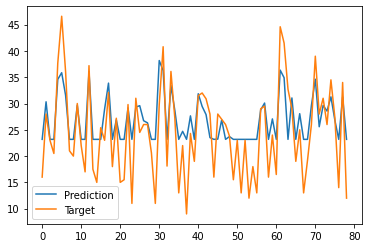

In [14]:
prediction = model(test_inputs)
print("Root Mean Squared Error: {:.3f}".format(np.sqrt(np.mean((test_target-prediction)**2))))

prediction = prediction*scaled_features['mpg'][1] + scaled_features['mpg'][0]
test_target1 = test_target*scaled_features['mpg'][1] + scaled_features['mpg'][0]
#Values are unnormalised
plt.plot(prediction, label = 'Prediction')
plt.plot(test_target1, label = 'Target')
plt.legend()